## 1. Источники данных и готового кода

- Источник данных 

    - https://fbref.com/ - данные с web-сайта
    - https://github.com/statsbomb/statsbombpy - данные через StatsBomb API

- Готовый парсер https://github.com/parth1902/Scrape-FBref-data/blob/master/Scrape_FBref.ipynb

- Построения радаров StatsBomb https://github.com/Slothfulwave612/soccerplots/blob/master/docs/radar_chart.md
- StatsBomb radar для Мбаппе - https://twitter.com/StatsBombES/status/1451139414504128513

## 2. Импорт библиотек

In [3]:
# !pip install soccerplots

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
import time
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import Image
from soccerplots.radar_chart import Radar
import warnings
warnings.filterwarnings("ignore")

## 3. Готовые функции для парсинга данных (копируем из Scrape_FBref.ipynb) + добавляем некоторые новые

#### Фунция get_tables
- получаем html-код таблиц с данными по соответствующему url адресу

In [2]:
def get_tables(url):
    res = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")
    team_table = all_tables[0]
    team_table_vs = all_tables[1]
    player_table = all_tables[2]
    return player_table, team_table, team_table_vs

#### демонстрация работы get_tables:

- url адрес для АПЛ 2021-2020, стандартный набор статистик

'https://fbref.com/en/comps/9/stats/Premier-League-Stats'

In [3]:
url = 'https://fbref.com/en/comps/9/stats/Premier-League-Stats'

player_table, team_table, team_table_vs = get_tables(url)

In [104]:
player_table.findAll('tr')[0]

<tr><th class="right" data-stat="ranker" scope="row">1</th><td class="left" csk="Aarons, Max" data-append-csv="774cf58b" data-stat="player"><a href="/en/players/774cf58b/Max-Aarons">Max Aarons</a></td><td class="left poptip" data-stat="nationality" data-tip="YNT"><a href="/en/country/ENG/England-Football"><span style="white-space: nowrap"><span class="f-i f-gb-eng" style="">eng</span> ENG</span></a></td><td class="center" csk="2.0" data-stat="position">DF</td><td class="left" data-stat="squad"><a href="/en/squads/1c781004/Norwich-City-Stats">Norwich City</a></td><td class="center" data-stat="age">21-318</td><td class="center" data-stat="birth_year">2000</td><td class="right" data-stat="minutes_90s">11.0</td><td class="right iz" data-stat="goals">0</td><td class="right" data-stat="shots_total">8</td><td class="right" data-stat="shots_on_target">1</td><td class="right" data-stat="shots_on_target_pct">12.5</td><td class="right" data-stat="shots_total_per90">0.73</td><td class="right" data

In [5]:
type(player_table)

bs4.element.Tag

- функция get_tables возвращает три объекта, в которых хранится html-код таблиц с сайта


    - player_table - статистика по игрокам
    - team_table - статистика по командам
    - team_table_vs - статистика по сопреникам
    
    
- каждая таблица на сайте fbref это **html код**, представленный набором **тегов** (т.е. таблица со статистиками, которую вы видите на экране браузера, представлена в виде кода, приведенного выше для демонстрации - player_table) 

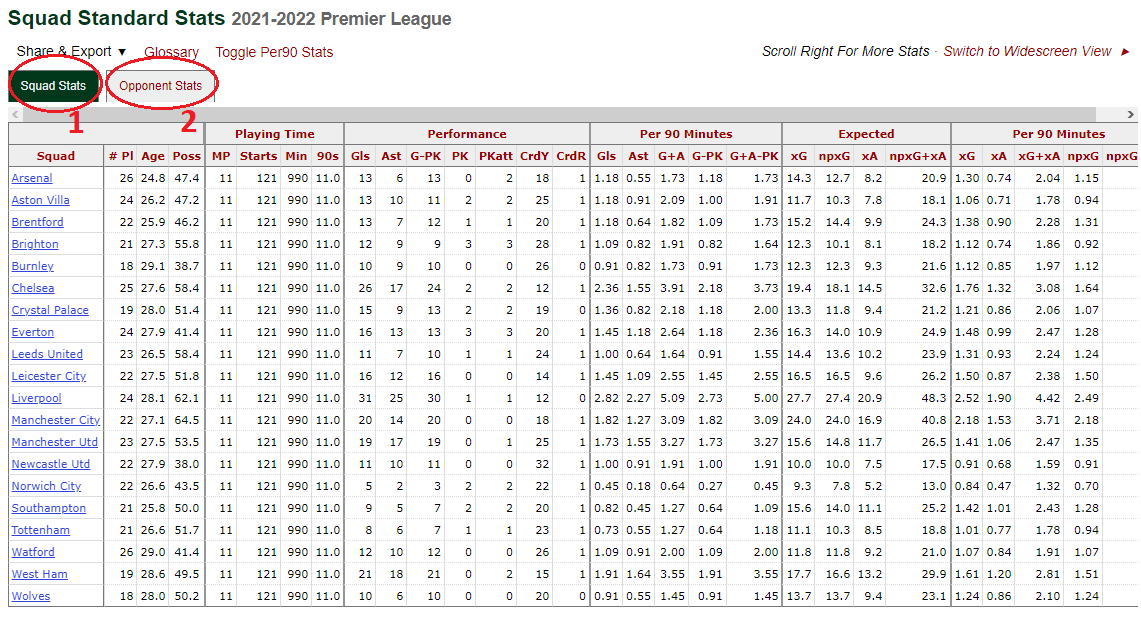

In [6]:
Image(r'./pictures/1.png')

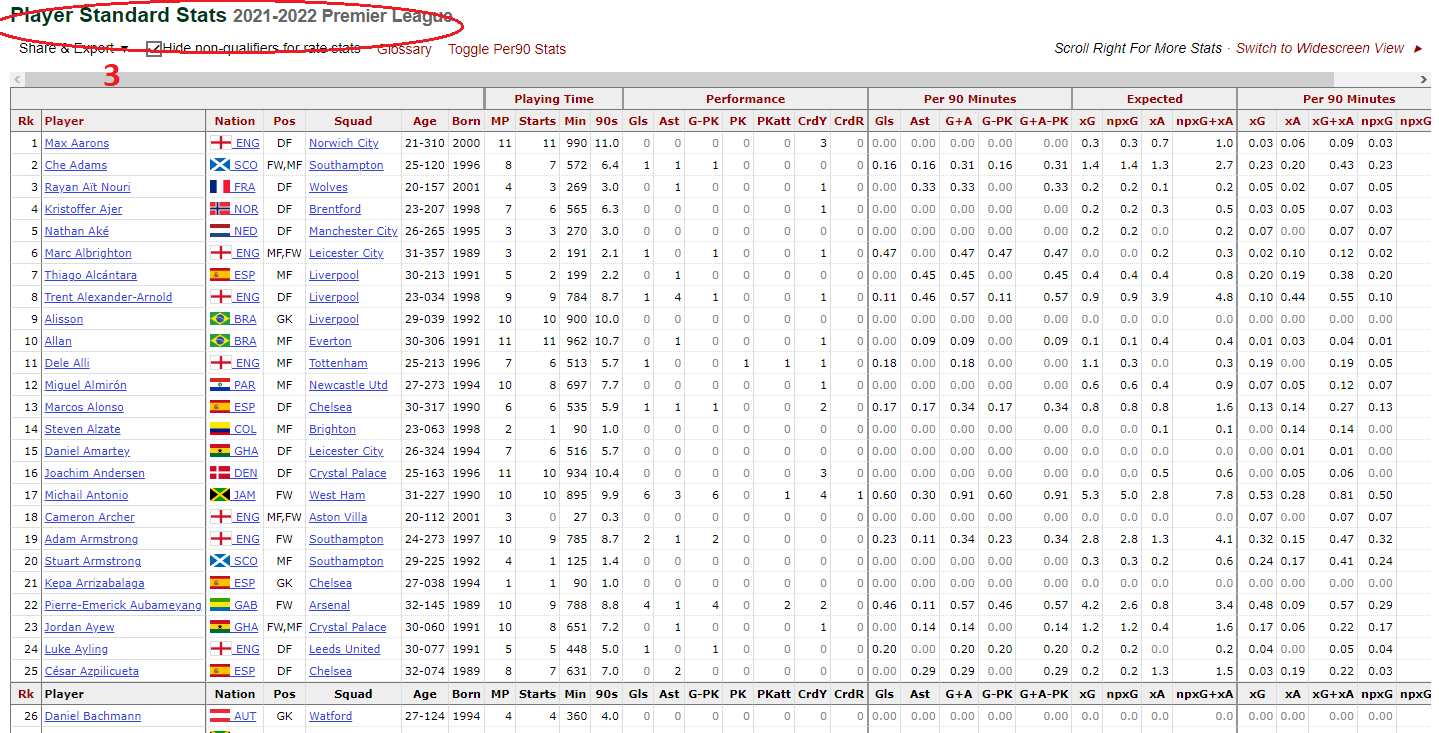

In [7]:
Image(r'./pictures/2.png')

#### Функция get_column_name

- отсутствовала в исходном ноутбуке - Scrape_FBref.ipynb
- каждый класс метрик хранится в соответствующей таблице


    - есть несколько таблиц для статистики по игрокам
    - есть несколько таблиц для статистик по командам
    - есть несколько таблиц для статистики против команд
    
    
- функция get_column_name для всех классов метрик (удары, пасы, оборонительные действия) и для каждого типа таблиц (по игрокам, по командам, против команд)  возвращает названия столбцов в соответствующих таблицах (названия метрик)

- чтобы написанный ранее парсер корректно работал, пришлось в функции get_column_name дополнительно поставить фильтр на ряд колонок - ranker / matches / squad (самое простое решение проблемы). В оригинальном ноутбуке Scrape_FBref.ipynb названия колонок задавались вручную, это чревато тем, что со временем, при изменении структуры таблиц, он может перестать работать. Я столкнулся именно с этой проблемой, когда разбирад код.

In [8]:
def get_column_name(top, end, category, type_table):
    
    url = (top + category + end)
    
    player_table, team_table, team_table_vs = get_tables(url)
    
    if type_table == 'player':
        table = player_table
    elif type_table == 'team':
        table = team_table
    elif type_table == 'team_vs':
        table = team_table_vs
        
    lst = []
    rows = table.find_all('tr')
    
    for row in rows[0].findAll():
        try:
            column_name = row['data-stat']
            if (type_table == 'player') and (column_name != 'ranker') and (column_name != 'matches'):
                lst.append(row['data-stat'])
            elif (type_table != 'player') and (column_name != 'squad'): 
                lst.append(row['data-stat'])
        except Exception as e:
            pass
    return lst

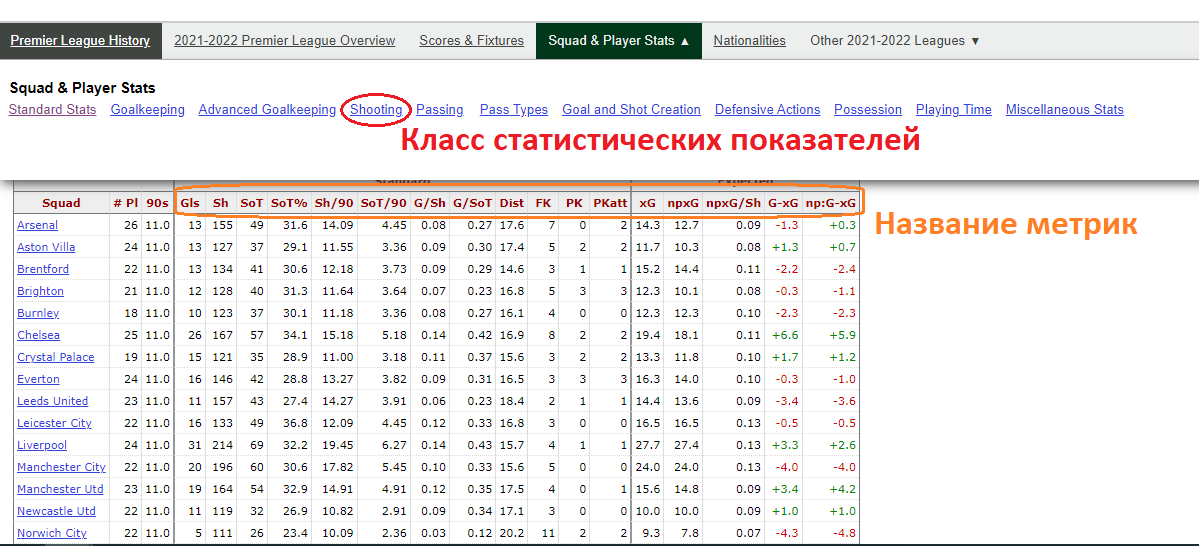

In [10]:
Image(r'./pictures/3.png')

#### демононстрация работы get_column_name

- искомый url адрес 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats' разбивается на три составляющие
- отдельно выделяем класс метрик через переменную 
    - category = 'shooting'

In [11]:
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'
category = 'shooting'
type_table = 'player'
column_name = get_column_name(top, end, category, type_table)
column_name

['player',
 'nationality',
 'position',
 'squad',
 'age',
 'birth_year',
 'minutes_90s',
 'goals',
 'shots_total',
 'shots_on_target',
 'shots_on_target_pct',
 'shots_total_per90',
 'shots_on_target_per90',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'average_shot_distance',
 'shots_free_kicks',
 'pens_made',
 'pens_att',
 'xg',
 'npxg',
 'npxg_per_shot',
 'xg_net',
 'npxg_net']

In [12]:
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'
category = 'shooting'
type_table = 'team'
column_name = get_column_name(top, end, category, type_table)
column_name

['players_used',
 'minutes_90s',
 'goals',
 'shots_total',
 'shots_on_target',
 'shots_on_target_pct',
 'shots_total_per90',
 'shots_on_target_per90',
 'goals_per_shot',
 'goals_per_shot_on_target',
 'average_shot_distance',
 'shots_free_kicks',
 'pens_made',
 'pens_att',
 'xg',
 'npxg',
 'npxg_per_shot',
 'xg_net',
 'npxg_net']

#### Функции get_frame и get_frame_team

- преобразует html-код в DataFrame - таблицу, с которой дальше удобно работать 
- get_frame - для формирования таблицы со статистикой по игрокам
- get_frame_team - для формирования таблицы со статистикой по командам
- на вход подаем:
    - features - названия колонок в таблицах (получили на предыдущем шаге)
    - player_table или team_table

In [14]:

def get_frame(features, player_table):
    pre_df_player = dict()
    features_wanted_player = features
    rows_player = player_table.find_all('tr')
    for row in rows_player:
        if(row.find('th',{"scope":"row"}) != None):
    
            for f in features_wanted_player:
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if(text == ''):
                    text = '0'
                if((f!='player')&(f!='nationality')&(f!='position')&(f!='squad')&(f!='age')&(f!='birth_year')):
                    text = float(text.replace(',',''))
                if f in pre_df_player:
                    pre_df_player[f].append(text)
                else:
                    pre_df_player[f] = [text]
    df_player = pd.DataFrame.from_dict(pre_df_player)
    return df_player

def get_frame_team(features, team_table):
    pre_df_squad = dict()
    features_wanted_squad = features
    rows_squad = team_table.find_all('tr')
    for row in rows_squad:
        if(row.find('th',{"scope":"row"}) != None):
            name = row.find('th',{"data-stat":"squad"}).text.strip().encode().decode("utf-8")
            if 'squad' in pre_df_squad:
                pre_df_squad['squad'].append(name)
            else:
                pre_df_squad['squad'] = [name]
            for f in features_wanted_squad:
                cell = row.find("td",{"data-stat": f})         
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if(text == ''):
                    text = '0'
                if((f!='player')&(f!='nationality')&(f!='position')&(f!='squad')&(f!='age')&(f!='birth_year')):
                    text = float(text.replace(',',''))
                if f in pre_df_squad:
                    pre_df_squad[f].append(text)
                else:
                    pre_df_squad[f] = [text]
    df_squad = pd.DataFrame.from_dict(pre_df_squad)
    return df_squad

#### демонстрация работы get_frame и get_frame_team

- получаем статистику по всем ударным метрикам для **игроков** АПЛ в виде DataFrame - таблицы

In [15]:
url = 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats'
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'
category = 'shooting'
type_table = 'player'

features = get_column_name(top, end, category, type_table)
player_table, team_table, team_table_vs = get_tables(url)

df_player = get_frame(features, player_table)

In [16]:
df_player.head()

,player,nationality,position,squad,age,birth_year,minutes_90s,goals,shots_total,shots_on_target,...,goals_per_shot_on_target,average_shot_distance,shots_free_kicks,pens_made,pens_att,xg,npxg,npxg_per_shot,xg_net,npxg_net
0,Max Aarons,eng ENG,DF,Norwich City,21-318,2000,11.0,0.0,8.0,1.0,...,0.0,21.7,0.0,0.0,0.0,0.3,0.3,0.04,-0.3,-0.3
1,Che Adams,sct SCO,"FW,MF",Southampton,25-128,1996,6.4,1.0,12.0,5.0,...,0.2,14.8,0.0,0.0,0.0,1.4,1.4,0.12,-0.4,-0.4
2,Rayan Aït Nouri,fr FRA,DF,Wolves,20-165,2001,3.0,0.0,2.0,1.0,...,0.0,14.8,0.0,0.0,0.0,0.2,0.2,0.08,-0.2,-0.2
3,Kristoffer Ajer,no NOR,DF,Brentford,23-215,1998,6.3,0.0,2.0,0.0,...,0.0,9.9,0.0,0.0,0.0,0.2,0.2,0.09,-0.2,-0.2
4,Nathan Aké,nl NED,DF,Manchester City,26-273,1995,3.0,0.0,1.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.2,0.2,0.20,-0.2,-0.2


- получаем статистику по всем ударным метрикам для **команд** АПЛ в виде DataFrame - таблицы

In [17]:
url = 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats'
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'
category = 'shooting'
type_table = 'team'

features = get_column_name(top, end, category, type_table)
player_table, team_table, team_table_vs = get_tables(url)

df_team = get_frame_team(features, team_table)

In [18]:
df_team.head()

,squad,players_used,minutes_90s,goals,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,average_shot_distance,shots_free_kicks,pens_made,pens_att,xg,npxg,npxg_per_shot,xg_net,npxg_net
0,Arsenal,26.0,11.0,13.0,155.0,49.0,31.6,14.09,4.45,0.08,0.27,17.6,7.0,0.0,2.0,14.3,12.7,0.09,-1.3,0.3
1,Aston Villa,24.0,11.0,13.0,127.0,37.0,29.1,11.55,3.36,0.09,0.30,17.4,5.0,2.0,2.0,11.7,10.3,0.08,1.3,0.7
2,Brentford,22.0,11.0,13.0,134.0,41.0,30.6,12.18,3.73,0.09,0.29,14.6,3.0,1.0,1.0,15.2,14.4,0.11,-2.2,-2.4
3,Brighton,21.0,11.0,12.0,128.0,40.0,31.3,11.64,3.64,0.07,0.23,16.8,5.0,3.0,3.0,12.3,10.1,0.08,-0.3,-1.1
4,Burnley,18.0,11.0,10.0,123.0,37.0,30.1,11.18,3.36,0.08,0.27,16.1,4.0,0.0,0.0,12.3,12.3,0.10,-2.3,-2.3


In [19]:
url = 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats'
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'
category = 'shooting'
type_table = 'team_vs'

features = get_column_name(top, end, category, type_table)
player_table, team_table, team_table_vs = get_tables(url)

df_team_vs = get_frame_team(features, team_table_vs)

In [20]:
df_team_vs.head()

,squad,players_used,minutes_90s,goals,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,average_shot_distance,shots_free_kicks,pens_made,pens_att,xg,npxg,npxg_per_shot,xg_net,npxg_net
0,vs Arsenal,26.0,11.0,13.0,155.0,47.0,30.3,14.09,4.27,0.08,0.28,16.1,4.0,0.0,0.0,16.5,16.5,0.11,-3.5,-3.5
1,vs Aston Villa,24.0,11.0,19.0,158.0,49.0,31.0,14.36,4.45,0.12,0.39,17.5,10.0,0.0,2.0,16.8,15.2,0.10,2.2,3.8
2,vs Brentford,22.0,11.0,14.0,122.0,38.0,31.1,11.09,3.45,0.11,0.34,18.1,8.0,1.0,1.0,12.7,11.9,0.10,1.3,1.1
3,vs Brighton,21.0,11.0,12.0,133.0,36.0,27.1,12.09,3.27,0.08,0.28,18.4,5.0,2.0,2.0,14.1,12.6,0.10,-2.1,-2.6
4,vs Burnley,18.0,11.0,17.0,183.0,48.0,26.2,16.64,4.36,0.09,0.35,16.4,6.0,0.0,0.0,17.7,17.7,0.10,-0.7,-0.7


#### Функции frame_for_category и frame_for_category_team

- объединяют в себе ранее написанные функции
    - get_tables и get_frame для получения DataFrame со статистиками по игрокам
    - get_tables и get_frame_team с team_table на входе для получения DataFrame со статистиками по командам
    - get_tables и get_frame_team с team_table_vs на входе для получения DataFrame со статистикой против команд

In [21]:
def frame_for_category(category,top,end,features):
    url = (top + category + end)
    player_table, team_table, team_table_vs = get_tables(url)
    df_player = get_frame(features, player_table)
    return df_player

def frame_for_category_team(category,top,end,features):
    url = (top + category + end)
    player_table, team_table, team_table_vs = get_tables(url)
    df_team = get_frame_team(features, team_table)
    return df_team

def frame_for_category_team_vs(category,top,end,features):
    url = (top + category + end)
    player_table, team_table, team_table_vs = get_tables(url)
    df_team = get_frame_team(features, team_table_vs)
    return df_team


#### Функции:

- get_outfield_data - все типы статистик по игрокам (outfield players - полевые игроки )
- get_keeper_data - все типы статистик по вратарям 
- get_team_data - все типы статистик по командам
- get_team_data_vs - все типы статистик против команд

In [22]:
def get_outfield_data(top, end, dict_res, type_table='player'):
    
    df1 = frame_for_category('stats',top,end, dict_res[type_table]['stats'])
    df2 = frame_for_category('shooting',top,end, dict_res[type_table]['shooting'])
    df3 = frame_for_category('passing',top,end,dict_res[type_table]['passing'])
    df4 = frame_for_category('passing_types',top,end,dict_res[type_table]['passing_types'])
    df5 = frame_for_category('gca',top,end, dict_res[type_table]['gca'])
    df6 = frame_for_category('defense',top,end, dict_res[type_table]['defense'])
    df7 = frame_for_category('possession',top,end, dict_res[type_table]['possession'])
    df8 = frame_for_category('misc',top,end, dict_res[type_table]['misc'])

    df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    
    print('get_outfield_data for ' + end + ' is loaded')
    return df

def get_keeper_data(top,end, dict_res, type_table='player'):
    
    df1 = frame_for_category('keepers',top,end, dict_res[type_table]['keepers'])
    df2 = frame_for_category('keepersadv',top,end, dict_res[type_table]['keepersadv'])
    df = pd.concat([df1, df2], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    
    print('get_keeper_data for' + end + ' is loaded')
    return df

def get_team_data(top,end, dict_res, type_table='team'):
    
    
    df1 = frame_for_category_team('stats',top,end, dict_res[type_table]['stats'])
    df2 = frame_for_category_team('keepers',top,end, dict_res[type_table]['keepers'])
    df3 = frame_for_category_team('keepersadv',top,end, dict_res[type_table]['keepersadv'])
    df4 = frame_for_category_team('shooting',top,end, dict_res[type_table]['shooting'])
    df5 = frame_for_category_team('passing',top,end,dict_res[type_table]['passing'])
    df6 = frame_for_category_team('passing_types',top,end,dict_res[type_table]['passing_types'])
    df7 = frame_for_category_team('gca',top,end, dict_res[type_table]['gca'])
    df8 = frame_for_category_team('defense',top,end, dict_res[type_table]['defense'])
    df9 = frame_for_category_team('possession',top,end, dict_res[type_table]['possession'])
    df10 = frame_for_category_team('misc',top,end, dict_res[type_table]['misc'])
    
    df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    
    print('get_team_data for' + end + ' is loaded')
    return df

def get_team_data_vs(top,end, dict_res, type_table='team_vs'):
     
    df1 = frame_for_category_team('stats',top,end, dict_res[type_table]['stats'])
    df2 = frame_for_category_team('keepers',top,end, dict_res[type_table]['keepers'])
    df3 = frame_for_category_team('keepersadv',top,end, dict_res[type_table]['keepersadv'])
    df4 = frame_for_category_team('shooting',top,end, dict_res[type_table]['shooting'])
    df5 = frame_for_category_team('passing',top,end,dict_res[type_table]['passing'])
    df6 = frame_for_category_team('passing_types',top,end,dict_res[type_table]['passing_types'])
    df7 = frame_for_category_team('gca',top,end, dict_res[type_table]['gca'])
    df8 = frame_for_category_team('defense',top,end, dict_res[type_table]['defense'])
    df9 = frame_for_category_team('possession',top,end, dict_res[type_table]['possession'])
    df10 = frame_for_category_team('misc',top,end, dict_res[type_table]['misc'])
    
    df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    
    print('get_team_data_vs for' + end + ' is loaded')
    return df

## 4. Получаем готовые таблицы с полным перечнем статистических показателей за один сезон (текущий 2021-2022)

- предварительно сформируем перечень названий колонок для каждого типа таблицы ('player','team', 'team_vs')
- с сезона 2017-2018 названия колонок не меняются (после добавления данных от StatsBomb)
- будем использовать ссылку на текущую статистику АПЛ (можно взять люой другой TOP чемпионат)
- записываем результаты в словарь dict_res

In [23]:
%%time
top = 'https://fbref.com/en/comps/9/'
end = '/Premier-League-Stats'

dict_res = {}
for type_table in ['player', 'team', 'team_vs']:
    
    for type_stat in ['stats', 'shooting', 'passing', 'passing_types', 
                      'gca', 'defense', 'possession', 'misc', 'keepers', 'keepersadv']:
        
        columns = get_column_name(top, end, type_stat, type_table)
        
        if type_table not in dict_res.keys():
            dict_res[type_table] = {type_stat:columns}
        else:
            dict_res[type_table][type_stat] = columns

Wall time: 59.5 s


- получаем таблицы с польной статистикой по текущему сезону

#### АПЛ 2021, статистика по полевым игрокам

In [24]:
%%time
df_outfield_NOW_EPL = get_outfield_data('https://fbref.com/en/comps/9/','/Premier-League-Stats', dict_res)

get_outfield_data for /Premier-League-Stats is loaded
Wall time: 39.9 s


In [25]:
df_outfield_NOW_EPL.head()

,player,nationality,position,squad,age,birth_year,games,games_starts,minutes,minutes_90s,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,Max Aarons,eng ENG,DF,Norwich City,21-318,2000,11.0,11.0,990.0,11.0,...,9.0,22.0,1.0,0.0,0.0,1.0,58.0,5.0,20.0,20.0
1,Che Adams,sct SCO,"FW,MF",Southampton,25-128,1996,8.0,7.0,572.0,6.4,...,15.0,17.0,2.0,0.0,0.0,0.0,35.0,16.0,34.0,32.0
2,Rayan Aït Nouri,fr FRA,DF,Wolves,20-165,2001,4.0,3.0,269.0,3.0,...,5.0,4.0,0.0,0.0,0.0,0.0,24.0,0.0,3.0,0.0
3,Kristoffer Ajer,no NOR,DF,Brentford,23-215,1998,7.0,6.0,565.0,6.3,...,5.0,10.0,0.0,0.0,0.0,0.0,55.0,21.0,9.0,70.0
4,Nathan Aké,nl NED,DF,Manchester City,26-273,1995,3.0,3.0,270.0,3.0,...,4.0,1.0,0.0,0.0,0.0,0.0,17.0,14.0,0.0,100.0


#### АПЛ 2021, статистика по вратярям

In [26]:
%%time
df_keeper_NOW_EPL = get_keeper_data('https://fbref.com/en/comps/9/','/Premier-League-Stats', dict_res)

get_keeper_data for/Premier-League-Stats is loaded
Wall time: 1.28 s


In [27]:
df_keeper_NOW_EPL.head()

,player,nationality,position,squad,age,birth_year,games_gk,games_starts_gk,minutes_gk,minutes_90s,...,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk
0,Alisson,br BRA,GK,Liverpool,29-047,1992,10.0,10.0,900.0,10.0,...,30.6,56.0,48.2,40.9,85.0,9.0,10.6,13.0,1.30,16.6
1,Kepa Arrizabalaga,es ESP,GK,Chelsea,27-046,1994,1.0,1.0,90.0,1.0,...,30.0,4.0,0.0,9.3,8.0,1.0,12.5,1.0,1.00,18.0
2,Daniel Bachmann,at AUT,GK,Watford,27-132,1994,4.0,4.0,360.0,4.0,...,35.4,35.0,34.3,36.2,38.0,2.0,5.3,1.0,0.25,12.2
3,Asmir Begović,ba BIH,GK,Everton,34-151,1987,1.0,1.0,90.0,1.0,...,50.5,12.0,66.7,49.6,5.0,1.0,20.0,0.0,0.00,15.0
4,Karl Darlow,eng ENG,GK,Newcastle Utd,31-041,1990,7.0,7.0,630.0,7.0,...,49.7,58.0,75.9,58.8,60.0,7.0,11.7,4.0,0.57,15.1


#### АПЛ 2021, статистика по командам

In [29]:
%%time
df_team_NOW_EPL = get_team_data('https://fbref.com/en/comps/9/','/Premier-League-Stats', dict_res)

get_team_data for/Premier-League-Stats is loaded
Wall time: 12.9 s


In [30]:
df_team_NOW_EPL.head()

,squad,players_used,avg_age,possession,games,games_starts,minutes,minutes_90s,goals,assists,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,Arsenal,26.0,24.8,47.4,11.0,121.0,990.0,11.0,13.0,6.0,...,100.0,100.0,21.0,2.0,0.0,0.0,855.0,178.0,193.0,48.0
1,Aston Villa,24.0,26.3,47.2,11.0,121.0,990.0,11.0,13.0,10.0,...,118.0,146.0,16.0,1.0,2.0,1.0,904.0,208.0,213.0,49.4
2,Brentford,22.0,26.0,46.2,11.0,121.0,990.0,11.0,13.0,7.0,...,120.0,111.0,22.0,1.0,1.0,0.0,1034.0,259.0,244.0,51.5
3,Brighton,21.0,27.3,55.8,11.0,121.0,990.0,11.0,12.0,9.0,...,108.0,85.0,16.0,2.0,2.0,0.0,886.0,158.0,166.0,48.8
4,Burnley,18.0,29.1,38.7,11.0,121.0,990.0,11.0,10.0,9.0,...,103.0,82.0,33.0,0.0,0.0,0.0,1008.0,284.0,255.0,52.7


#### АПЛ 2021, статистика по соперникам (против команды)

In [31]:
%%time
df_team_vs_NOW_EPL = get_team_data_vs('https://fbref.com/en/comps/9/','/Premier-League-Stats', dict_res)

get_team_data_vs for/Premier-League-Stats is loaded
Wall time: 11.6 s


In [32]:
df_team_vs_NOW_EPL.head()

,squad,players_used,avg_age,possession,games,games_starts,minutes,minutes_90s,goals,assists,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,Arsenal,26.0,24.8,47.4,11.0,121.0,990.0,11.0,13.0,6.0,...,100.0,100.0,21.0,2.0,0.0,0.0,855.0,178.0,193.0,48.0
1,Aston Villa,24.0,26.3,47.2,11.0,121.0,990.0,11.0,13.0,10.0,...,118.0,146.0,16.0,1.0,2.0,1.0,904.0,208.0,213.0,49.4
2,Brentford,22.0,26.0,46.2,11.0,121.0,990.0,11.0,13.0,7.0,...,120.0,111.0,22.0,1.0,1.0,0.0,1034.0,259.0,244.0,51.5
3,Brighton,21.0,27.3,55.8,11.0,121.0,990.0,11.0,12.0,9.0,...,108.0,85.0,16.0,2.0,2.0,0.0,886.0,158.0,166.0,48.8
4,Burnley,18.0,29.1,38.7,11.0,121.0,990.0,11.0,10.0,9.0,...,103.0,82.0,33.0,0.0,0.0,0.0,1008.0,284.0,255.0,52.7


## 5. Отдельно напишем функцию для получения url адресов со статистикой за прошлые годы

- Для построения радаров по текущему сезону нужно иметь информацию по TOP5 чемпионатам за последние 5 лет 
- На fbref статитсика от StatsBomb доступна начиная с сезона 2017-2018 (т.е. есть 4 полноценных сезона и текущий пятый)

In [28]:
def get_urls(year_start, seasons, url_hist):
    
    res = requests.get(url_hist)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    
    years = [str(year_start - i-1)+'-'+str(year_start - i) for i in range(seasons)]
    
    urls = []
    
    hrefs = [row['href'] for row in soup.find_all('a', href=True)]
    
    league_name = url_hist.split('/')[-1].replace('Seasons','Stats')
    
    for href in hrefs:
        for yr in years:
            if (yr in href) and (league_name in href):
                urls.append('https://fbref.com'+href)
                
    unique_urls = np.unique(urls, axis=0)
    
    unique_urls = sorted(unique_urls, key=lambda x: int(x.split('/')[-1].split('-')[1]), reverse=True)
                
    return unique_urls

#### Ссылки на статистику по АПЛ

In [29]:
url = 'https://fbref.com/en/comps/9/history/Premier-League-Seasons'

get_urls(2021, 4, url)

['https://fbref.com/en/comps/9/10728/2020-2021-Premier-League-Stats',
 'https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/1631/2017-2018-Premier-League-Stats']

#### Ссылки на статистику по Бундеслиге

In [30]:
url = 'https://fbref.com/en/comps/20/history/Bundesliga-Seasons'

get_urls(2021, 4, url)

['https://fbref.com/en/comps/20/10737/2020-2021-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/3248/2019-2020-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2109/2018-2019-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/1634/2017-2018-Bundesliga-Stats']

#### Ссылки на статистику по Ла Лиге

In [31]:
url = 'https://fbref.com/en/comps/12/history/La-Liga-Seasons'

get_urls(2021, 4, url)

['https://fbref.com/en/comps/12/10731/2020-2021-La-Liga-Stats',
 'https://fbref.com/en/comps/12/3239/2019-2020-La-Liga-Stats',
 'https://fbref.com/en/comps/12/1886/2018-2019-La-Liga-Stats',
 'https://fbref.com/en/comps/12/1652/2017-2018-La-Liga-Stats']

#### Ссылки на статистику по Серии А

In [32]:
url = 'https://fbref.com/en/comps/11/history/Serie-A-Seasons'

get_urls(2021, 4, url)

['https://fbref.com/en/comps/11/10730/2020-2021-Serie-A-Stats',
 'https://fbref.com/en/comps/11/3260/2019-2020-Serie-A-Stats',
 'https://fbref.com/en/comps/11/1896/2018-2019-Serie-A-Stats',
 'https://fbref.com/en/comps/11/1640/2017-2018-Serie-A-Stats']

#### Ссылки на статистику по Лиге 1

In [33]:
url = 'https://fbref.com/en/comps/13/history/Ligue-1-Seasons'

get_urls(2021, 4, url)

['https://fbref.com/en/comps/13/10732/2020-2021-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/3243/2019-2020-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2104/2018-2019-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/1632/2017-2018-Ligue-1-Stats']

## 6. Собираем итоговые таблицы со статистикой по каждой лиге за последние 4 полных сезона

- 2020-2021
- 2019-2020
- 2018-2019
- 2017-2018

In [39]:
%%time
lst_leagues = [(9,'Premier-League-Seasons'),
               (20,'Bundesliga-Seasons'), 
               (12,'La-Liga-Seasons'),
               (11,'Serie-A-Seasons'),
               (13,'Ligue-1-Seasons')]

lst_outfields = []
lst_keeper = []
lst_team = []
lst_team_vs = []

for league in tqdm(lst_leagues):

    url_hist = f'https://fbref.com/en/comps/{league[0]}/history/' + league[1]
    urls = get_urls(2021, 4, url_hist)
    
    for url in urls:
        
        left_url = url.rsplit('/',1)[0] + '/'
        right_url = '/' + url.rsplit('/',1)[1]  
        
        year_start = url.rsplit('/',1)[1].split('-')[0]
        year_end = url.rsplit('/',1)[1].split('-')[1]
        
        season = year_start + '-' + year_end
        league_name = league[1].rsplit('-',1)[0]
# Если вы решите собирать более ранние сезоны, то структура таблиц будет несколько иная, 
# поэтому каждый раз придется перепроверять список колонок (но возможно только один раз - для сезонов 2016-2017 и более ранних)           
#         dict_res = {}
        
#         for type_table in ['player', 'team', 'team_vs']:

#             for type_stat in ['stats', 'shooting', 'passing', 'passing_types', 
#                               'gca', 'defense', 'possession', 'misc', 'keepers', 'keepersadv']:

#                 columns = get_column_name(left_url, right_url, type_stat, type_table)

#                 if type_table not in dict_res.keys():
#                     dict_res[type_table] = {type_stat:columns}
#                 else:
#                     dict_res[type_table][type_stat] = columns
        

        df_outfield = get_outfield_data(left_url, right_url, dict_res)
        df_keeper = get_keeper_data(left_url, right_url, dict_res)
        df_team = get_team_data(left_url, right_url, dict_res)
        df_team_vs = get_team_data_vs(left_url, right_url, dict_res)
        
        df_outfield.insert(0,'season',season)
        df_keeper.insert(0,'season',season)
        df_team.insert(0,'season',season)
        df_team_vs.insert(0,'season',season)
        
        df_outfield.insert(1,'league_name',league_name)
        df_keeper.insert(1,'league_name',league_name)
        df_team.insert(1,'league_name',league_name)
        df_team_vs.insert(1,'league_name',league_name)
    
        
        lst_outfields.append(df_outfield)
        lst_keeper.append(df_keeper)
        lst_team.append(df_team)
        lst_team_vs.append(df_team_vs)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

get_outfield_data for /2020-2021-Premier-League-Stats is loaded
get_keeper_data for/2020-2021-Premier-League-Stats is loaded
get_team_data for/2020-2021-Premier-League-Stats is loaded
get_team_data_vs for/2020-2021-Premier-League-Stats is loaded
get_outfield_data for /2019-2020-Premier-League-Stats is loaded
get_keeper_data for/2019-2020-Premier-League-Stats is loaded
get_team_data for/2019-2020-Premier-League-Stats is loaded
get_team_data_vs for/2019-2020-Premier-League-Stats is loaded
get_outfield_data for /2018-2019-Premier-League-Stats is loaded
get_keeper_data for/2018-2019-Premier-League-Stats is loaded
get_team_data for/2018-2019-Premier-League-Stats is loaded
get_team_data_vs for/2018-2019-Premier-League-Stats is loaded
get_outfield_data for /2017-2018-Premier-League-Stats is loaded
get_keeper_data for/2017-2018-Premier-League-Stats is loaded
get_team_data for/2017-2018-Premier-League-Stats is loaded


 20%|████████████████▌                                                                  | 1/5 [03:45<15:00, 225.25s/it]

get_team_data_vs for/2017-2018-Premier-League-Stats is loaded
get_outfield_data for /2020-2021-Bundesliga-Stats is loaded
get_keeper_data for/2020-2021-Bundesliga-Stats is loaded
get_team_data for/2020-2021-Bundesliga-Stats is loaded
get_team_data_vs for/2020-2021-Bundesliga-Stats is loaded
get_outfield_data for /2019-2020-Bundesliga-Stats is loaded
get_keeper_data for/2019-2020-Bundesliga-Stats is loaded
get_team_data for/2019-2020-Bundesliga-Stats is loaded
get_team_data_vs for/2019-2020-Bundesliga-Stats is loaded
get_outfield_data for /2018-2019-Bundesliga-Stats is loaded
get_keeper_data for/2018-2019-Bundesliga-Stats is loaded
get_team_data for/2018-2019-Bundesliga-Stats is loaded
get_team_data_vs for/2018-2019-Bundesliga-Stats is loaded
get_outfield_data for /2017-2018-Bundesliga-Stats is loaded
get_keeper_data for/2017-2018-Bundesliga-Stats is loaded
get_team_data for/2017-2018-Bundesliga-Stats is loaded


 40%|█████████████████████████████████▏                                                 | 2/5 [07:49<11:32, 230.99s/it]

get_team_data_vs for/2017-2018-Bundesliga-Stats is loaded
get_outfield_data for /2020-2021-La-Liga-Stats is loaded
get_keeper_data for/2020-2021-La-Liga-Stats is loaded
get_team_data for/2020-2021-La-Liga-Stats is loaded
get_team_data_vs for/2020-2021-La-Liga-Stats is loaded
get_outfield_data for /2019-2020-La-Liga-Stats is loaded
get_keeper_data for/2019-2020-La-Liga-Stats is loaded
get_team_data for/2019-2020-La-Liga-Stats is loaded
get_team_data_vs for/2019-2020-La-Liga-Stats is loaded
get_outfield_data for /2018-2019-La-Liga-Stats is loaded
get_keeper_data for/2018-2019-La-Liga-Stats is loaded
get_team_data for/2018-2019-La-Liga-Stats is loaded
get_team_data_vs for/2018-2019-La-Liga-Stats is loaded
get_outfield_data for /2017-2018-La-Liga-Stats is loaded
get_keeper_data for/2017-2018-La-Liga-Stats is loaded
get_team_data for/2017-2018-La-Liga-Stats is loaded


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:51<07:48, 234.24s/it]

get_team_data_vs for/2017-2018-La-Liga-Stats is loaded
get_outfield_data for /2020-2021-Serie-A-Stats is loaded
get_keeper_data for/2020-2021-Serie-A-Stats is loaded
get_team_data for/2020-2021-Serie-A-Stats is loaded
get_team_data_vs for/2020-2021-Serie-A-Stats is loaded
get_outfield_data for /2019-2020-Serie-A-Stats is loaded
get_keeper_data for/2019-2020-Serie-A-Stats is loaded
get_team_data for/2019-2020-Serie-A-Stats is loaded
get_team_data_vs for/2019-2020-Serie-A-Stats is loaded
get_outfield_data for /2018-2019-Serie-A-Stats is loaded
get_keeper_data for/2018-2019-Serie-A-Stats is loaded
get_team_data for/2018-2019-Serie-A-Stats is loaded
get_team_data_vs for/2018-2019-Serie-A-Stats is loaded
get_outfield_data for /2017-2018-Serie-A-Stats is loaded
get_keeper_data for/2017-2018-Serie-A-Stats is loaded
get_team_data for/2017-2018-Serie-A-Stats is loaded


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [15:58<03:58, 238.07s/it]

get_team_data_vs for/2017-2018-Serie-A-Stats is loaded
get_outfield_data for /2020-2021-Ligue-1-Stats is loaded
get_keeper_data for/2020-2021-Ligue-1-Stats is loaded
get_team_data for/2020-2021-Ligue-1-Stats is loaded
get_team_data_vs for/2020-2021-Ligue-1-Stats is loaded
get_outfield_data for /2019-2020-Ligue-1-Stats is loaded
get_keeper_data for/2019-2020-Ligue-1-Stats is loaded
get_team_data for/2019-2020-Ligue-1-Stats is loaded
get_team_data_vs for/2019-2020-Ligue-1-Stats is loaded
get_outfield_data for /2018-2019-Ligue-1-Stats is loaded
get_keeper_data for/2018-2019-Ligue-1-Stats is loaded
get_team_data for/2018-2019-Ligue-1-Stats is loaded
get_team_data_vs for/2018-2019-Ligue-1-Stats is loaded
get_outfield_data for /2017-2018-Ligue-1-Stats is loaded
get_keeper_data for/2017-2018-Ligue-1-Stats is loaded
get_team_data for/2017-2018-Ligue-1-Stats is loaded


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [20:02<00:00, 240.48s/it]

get_team_data_vs for/2017-2018-Ligue-1-Stats is loaded
Wall time: 20min 2s


- объединяем обработанные таблицы

In [41]:
DF_outfields_OLD_ALL = pd.concat(lst_outfields, axis=0)
DF_keeper_OLD_ALL = pd.concat(lst_keeper, axis=0)
DF_team_OLD_ALL = pd.concat(lst_team, axis=0)
DF_team_vs_OLD_ALL = pd.concat(lst_team_vs, axis=0)

- сохраняем на локальную машину (чтобы не повторять длительную процедуру вновь)

In [42]:
%%time
DF_outfields_OLD_ALL.to_csv('./outfields_17_18__20_21.csv')
DF_keeper_OLD_ALL.to_csv('./keeper_17_18__20_21.csv')
DF_team_OLD_ALL.to_csv('./team.csv_17_18__20_21')
DF_team_vs_OLD_ALL.to_csv('./team_vs_17_18__20_21')

Wall time: 1.3 s


## 7. Собираем итоговые таблицы со статистикой по каждой лиге за текущий сезон

- 2021-2022

In [19]:
%%time

season = '2021-2022'

lst_leagues = [(9,'Premier-League-Stats'),
               (20,'Bundesliga-Stats'), 
               (12,'La-Liga-Stats'),
               (11,'Serie-A-Stats'),
               (13,'Ligue-1-Stats')]

lst_outfields = []
lst_keeper = []
lst_team = []
lst_team_vs = []

for league in tqdm(lst_leagues):
    
    left_url = f'https://fbref.com/en/comps/{league[0]}/'
    right_url = '/' + league[1]  
    league_name = league[1].rsplit('-',1)[0]


    df_outfield = get_outfield_data(left_url, right_url, dict_res)
    df_keeper = get_keeper_data(left_url, right_url, dict_res)
    df_team = get_team_data(left_url, right_url, dict_res)
    df_team_vs = get_team_data_vs(left_url, right_url, dict_res)

    df_outfield.insert(0,'season',season)
    df_keeper.insert(0,'season',season)
    df_team.insert(0,'season',season)
    df_team_vs.insert(0,'season',season)

    df_outfield.insert(1,'league_name',league_name)
    df_keeper.insert(1,'league_name',league_name)
    df_team.insert(1,'league_name',league_name)
    df_team_vs.insert(1,'league_name',league_name)


    lst_outfields.append(df_outfield)
    lst_keeper.append(df_keeper)
    lst_team.append(df_team)
    lst_team_vs.append(df_team_vs)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

get_outfield_data for /Premier-League-Stats is loaded
get_keeper_data for/Premier-League-Stats is loaded
get_team_data for/Premier-League-Stats is loaded


 20%|████████████████▊                                                                   | 1/5 [01:14<04:57, 74.43s/it]

get_team_data_vs for/Premier-League-Stats is loaded
get_outfield_data for /Bundesliga-Stats is loaded
get_keeper_data for/Bundesliga-Stats is loaded
get_team_data for/Bundesliga-Stats is loaded


 40%|█████████████████████████████████▌                                                  | 2/5 [02:32<03:46, 75.55s/it]

get_team_data_vs for/Bundesliga-Stats is loaded
get_outfield_data for /La-Liga-Stats is loaded
get_keeper_data for/La-Liga-Stats is loaded
get_team_data for/La-Liga-Stats is loaded


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:57<02:36, 78.40s/it]

get_team_data_vs for/La-Liga-Stats is loaded
get_outfield_data for /Serie-A-Stats is loaded
get_keeper_data for/Serie-A-Stats is loaded
get_team_data for/Serie-A-Stats is loaded


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [05:26<01:21, 81.48s/it]

get_team_data_vs for/Serie-A-Stats is loaded
get_outfield_data for /Ligue-1-Stats is loaded
get_keeper_data for/Ligue-1-Stats is loaded
get_team_data for/Ligue-1-Stats is loaded


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:56<00:00, 83.32s/it]

get_team_data_vs for/Ligue-1-Stats is loaded
Wall time: 6min 56s


- объединяем обработанные таблицы

In [20]:
DF_outfields_NOW_ALL = pd.concat(lst_outfields, axis=0)
DF_keeper_NOW_ALL = pd.concat(lst_keeper, axis=0)
DF_team_NOW_ALL = pd.concat(lst_team, axis=0)
DF_team_vs_NOW_ALL = pd.concat(lst_team_vs, axis=0)

- сохраняем на локальную машину (данную процедуру придется повторять после каждого тура, чтобы получить обновленные таблицы по top5 чемпионатам, если какие-то чемпионаты не интересуют, их можно исключить из цикла)

In [21]:
%%time
DF_outfields_NOW_ALL.to_csv('./outfields_21_22.csv')
DF_keeper_NOW_ALL.to_csv('./keeper_21_22.csv')
DF_team_NOW_ALL.to_csv('./team.csv_21_22')
DF_team_vs_NOW_ALL.to_csv('./team_vs_21_22')

Wall time: 786 ms


## 8. Строим радар (по шаблону StatsBomb)

- считываем все предобработанные ранее таблицы (на случай, если вы не выполняли предыдущие ячейки, а скачали готовые таблицы с github)
- строим распределения для метрик по статистике за последние 4 сезона (StatsBomb использует 5)
- отмечаем на распределении текущее значение метрики (информация по текущему сезону)
- получаем из распределения границы для построения радара 
- строим шаблон радара (статистика за 4 сезона)
- отмечаем на радаре текущие значения метрик

#### Считываем данные

In [40]:
%%time

DF_outfields_NOW_ALL = pd.read_csv('./data/current_season_2021_2022/outfields_21_22.csv', index_col = 0).reset_index(drop=True)
DF_keeper_NOW_ALL = pd.read_csv('./data/current_season_2021_2022/keeper_21_22.csv', index_col = 0).reset_index(drop=True)
DF_team_NOW_ALL = pd.read_csv('./data/current_season_2021_2022/team_21_22.csv', index_col = 0).reset_index(drop=True)
DF_team_vs_NOW_ALL = pd.read_csv('./data/current_season_2021_2022/team_vs_21_22.csv', index_col = 0).reset_index(drop=True)

DF_outfields_OLD_ALL = pd.read_csv('./data/last_four_seasons/outfields_17_18__20_21.csv', index_col = 0).reset_index(drop=True)
DF_keeper_OLD_ALL = pd.read_csv('./data/last_four_seasons/keeper_17_18__20_21.csv', index_col = 0).reset_index(drop=True)
DF_team_OLD_ALL = pd.read_csv('./data/last_four_seasons/team_17_18__20_21.csv', index_col = 0).reset_index(drop=True)
DF_team_vs_OLD_ALL = pd.read_csv('./data/last_four_seasons/team_vs_17_18__20_21.csv', index_col = 0).reset_index(drop=True)



Wall time: 690 ms


#### Радар Мбаппе (текущий сезон)

- подробная статья о радарах https://www.sports.ru/tribuna/blogs/footsci/2887198.html

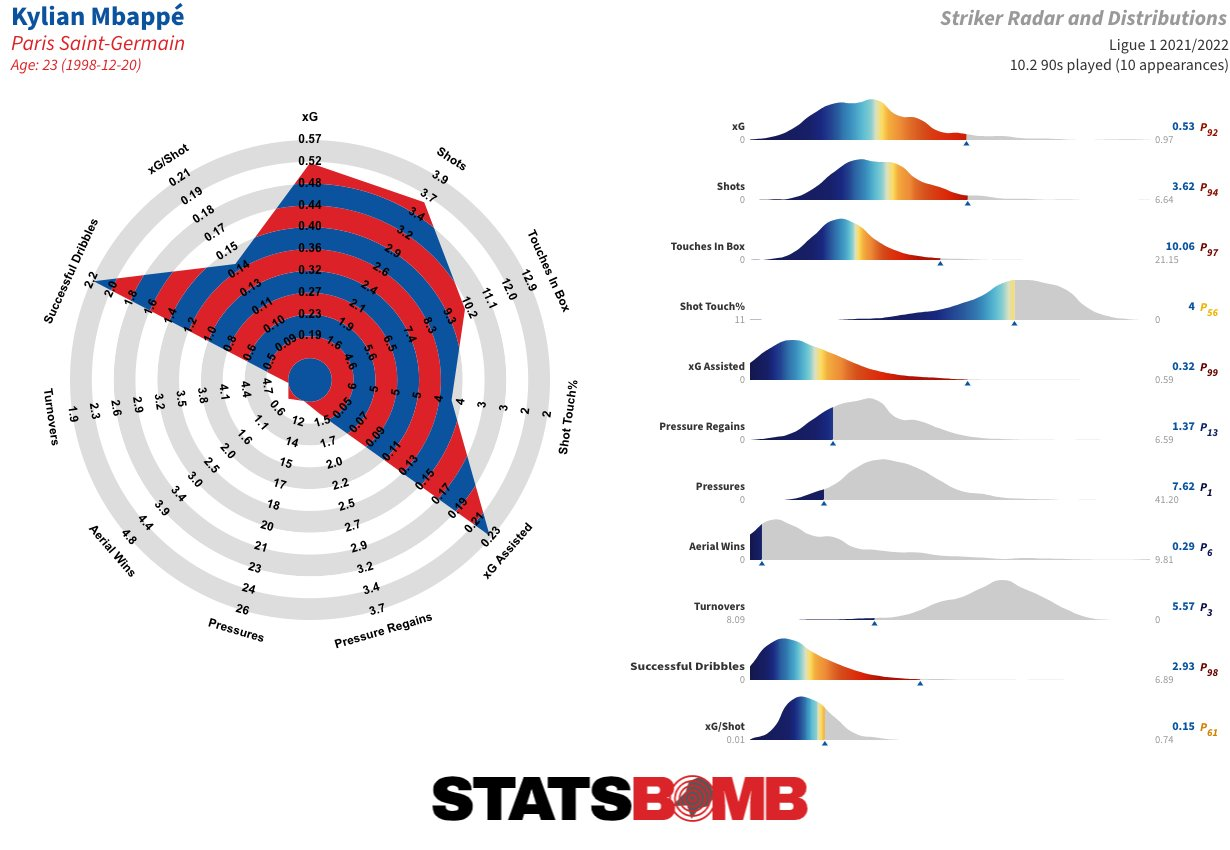

In [41]:
Image(r'./pictures/4.jpg')

### 8.1 Получим текущие значения метрик для Мбаппе в Лиге 1

- ищем то, как записан Мбаппе в таблице

In [42]:
df = DF_outfields_NOW_ALL.copy()

mask = df.player.apply(lambda x: x.find('Mba') != -1)
df[mask]

,season,league_name,player,nationality,position,squad,age,birth_year,games,games_starts,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
697,2021-2022,Bundesliga,Kevin Mbabu,ch SUI,DF,Wolfsburg,26-209,1995,11.0,8.0,...,17.0,12.0,2.0,0.0,0.0,0.0,84.0,25.0,8.0,75.8
1665,2021-2022,Serie-A,Ibrahima Mbaye,sn SEN,DF,Bologna,26-360,1994,2.0,1.0,...,2.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,66.7
2205,2021-2022,Ligue-1,Kylian Mbappé,fr FRA,FW,Paris S-G,22-329,1998,12.0,12.0,...,11.0,15.0,12.0,0.0,0.0,0.0,39.0,3.0,6.0,33.3


- ищем все метрики с радара

## xG

In [43]:
mask = df.columns.map(lambda x: x.find('xg') != -1)
df.columns[mask]

Index(['xg', 'npxg', 'npxg_xa', 'xg_per90', 'xg_xa_per90', 'npxg_per90',
       'npxg_xa_per90', 'npxg_per_shot', 'xg_net', 'npxg_net'],
      dtype='object')

- нас интересуют: npxg_per90

## Shots

In [44]:
mask = df.columns.map(lambda x: x.find('shot') != -1)
df.columns[mask]

Index(['shots_total', 'shots_on_target', 'shots_on_target_pct',
       'shots_total_per90', 'shots_on_target_per90', 'goals_per_shot',
       'goals_per_shot_on_target', 'average_shot_distance', 'shots_free_kicks',
       'npxg_per_shot', 'assisted_shots', 'sca_shots', 'gca_shots',
       'blocked_shots', 'blocked_shots_saves'],
      dtype='object')

- нас интересуют: shots_total_per90

## Touches in box

In [45]:
mask = df.columns.map(lambda x: x.find('touch') != -1)
df.columns[mask]

Index(['touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd',
       'touches_att_3rd', 'touches_att_pen_area', 'touches_live_ball'],
      dtype='object')

- нас интересуют: touches_att_pen_area

## Shot touches%

In [46]:
mask = df.columns.map(lambda x: (x.find('touch') != -1) | (x.find('shot') != -1))
df.columns[mask]

Index(['shots_total', 'shots_on_target', 'shots_on_target_pct',
       'shots_total_per90', 'shots_on_target_per90', 'goals_per_shot',
       'goals_per_shot_on_target', 'average_shot_distance', 'shots_free_kicks',
       'npxg_per_shot', 'assisted_shots', 'sca_shots', 'gca_shots',
       'blocked_shots', 'blocked_shots_saves', 'touches',
       'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd',
       'touches_att_3rd', 'touches_att_pen_area', 'touches_live_ball'],
      dtype='object')

- нас интересуют: shots_total и touches

## xGAssisted

In [47]:
mask = df.columns.map(lambda x: x.find('xa') != -1)
df.columns[mask]

Index(['xa', 'npxg_xa', 'xa_per90', 'xg_xa_per90', 'npxg_xa_per90', 'xa_net'], dtype='object')

- нас интересуют: npxg_xa_per90

## Pressure regains / Pressures

In [48]:
mask = df.columns.map(lambda x: x.find('pres') != -1)
df.columns[mask]

Index(['passes_pressure', 'pressures', 'pressure_regains',
       'pressure_regain_pct', 'pressures_def_3rd', 'pressures_mid_3rd',
       'pressures_att_3rd'],
      dtype='object')

- нас интересуют: pressure_regains / pressures

## Aerial Wins

In [49]:
mask = df.columns.map(lambda x: x.find('aer') != -1)
df.columns[mask]

Index(['aerials_won', 'aerials_lost', 'aerials_won_pct'], dtype='object')

- нас интересуют: aerials_won

## Turnovers

In [50]:
mask = df.columns.map(lambda x: x.find('turn') != -1)
df.columns[mask]

Index([], dtype='object')

- не нашли, смотрим определение Turnovers у StatsBomb

#### Turnovers 

- потери мяча, данная метрика считает сколько раз за игру нападающий теряет мяч во владении (потери из-за ошибок при приеме мяча и при неудачном ведении мяча или дриблинге)

Оригинальное определение от StatsBomb

- How often a player loses the ball via a miscontrol or a failed dribble per 90 minutes.
https://statsbomb.com/2018/08/new-data-new-statsbomb-radars/

In [51]:
mask = df.columns.map(lambda x: (x.find('mis') != -1) | (x.find('drib') != -1))
df.columns[mask]

Index(['sca_dribbles', 'gca_dribbles', 'dribble_tackles', 'dribbles_vs',
       'dribble_tackles_pct', 'dribbled_past', 'dribbles_completed',
       'dribbles', 'dribbles_completed_pct', 'players_dribbled_past',
       'miscontrols'],
      dtype='object')

- нас интересуют: miscontrols, dribbles и (dribbles_completed_pct или dribbles_completed)

## Successful dribbles

In [52]:
mask = df.columns.map(lambda x: x.find('dribb') != -1)
df.columns[mask]

Index(['sca_dribbles', 'gca_dribbles', 'dribble_tackles', 'dribbles_vs',
       'dribble_tackles_pct', 'dribbled_past', 'dribbles_completed',
       'dribbles', 'dribbles_completed_pct', 'players_dribbled_past'],
      dtype='object')

- нас интересуют: dribbles_completed

## xG/Shot

In [53]:
mask = df.columns.map(lambda x: x.find('xg') != -1)
df.columns[mask]

Index(['xg', 'npxg', 'npxg_xa', 'xg_per90', 'xg_xa_per90', 'npxg_per90',
       'npxg_xa_per90', 'npxg_per_shot', 'xg_net', 'npxg_net'],
      dtype='object')

- нас интересуют: npxg_per_shot

## Количество сыгранных интервалов по 90 минут

#### ! отличается от StatsBomb (fbref счиает чистое время, statsbomb - грязное (учитывает добавленные минуты))

In [54]:
mask = df.columns.map(lambda x: x.find('90') != -1)
df.columns[mask]

Index(['minutes_90s', 'goals_per90', 'assists_per90', 'goals_assists_per90',
       'goals_pens_per90', 'goals_assists_pens_per90', 'xg_per90', 'xa_per90',
       'xg_xa_per90', 'npxg_per90', 'npxg_xa_per90', 'shots_total_per90',
       'shots_on_target_per90', 'sca_per90', 'gca_per90'],
      dtype='object')

- нас интересуют: minutes_90s

#### Собираем все полученные значения, попутно рассчитывая некоторые производные метрики

In [55]:
df = DF_outfields_NOW_ALL.copy()

df_metrics = pd.DataFrame()

player = 'Kylian Mbappé'
mask = (df.player == player)

time_90s = df[mask]['minutes_90s'].values[0]
games = df[mask]['games'].values[0]

df_metrics['player'] =              [player]
df_metrics['appearances'] =         [games]
df_metrics['90s_played'] =          [time_90s]
df_metrics['xG'] =                  round(df[mask]['npxg'].values[0] / time_90s,2)
df_metrics['Shots'] =               round(df[mask]['shots_total'].values[0] / time_90s,2)
df_metrics['Touches in box'] =      round(df[mask]['touches_att_pen_area'].values[0] / time_90s,2)
df_metrics['Shot touches%'] =       round(df[mask]['shots_total'] / df[mask]['touches'],2).values[0]*100
df_metrics['xGAssisted'] =          round(df[mask]['xa'].values[0] / time_90s,2) 
df_metrics['Pressure regains'] =    round(df[mask]['pressure_regains'].values[0] / time_90s,2)
df_metrics['Pressures'] =           round(df[mask]['pressures'].values[0] / time_90s,2) 
df_metrics['Aerial Wins'] =         round(df[mask]['aerials_won'].values[0] / time_90s,2)

mis = df[mask]['miscontrols'].values[0]
drib_failed = df[mask]['dribbles'].values[0] - df[mask]['dribbles_completed'].values[0]

df_metrics['Turnovers'] =           round((mis + drib_failed) / time_90s,2)
df_metrics['Successful dribbles'] = round(df[mask]['dribbles_completed'].values[0] / time_90s,2)
df_metrics['xG/Shot'] =             round(df[mask]['npxg_per_shot'].values[0] ,2)
df_metrics = df_metrics.T
df_metrics.columns = ['Statistic']
df_metrics

,Statistic
player,Kylian Mbappé
appearances,12
90s_played,11.6
xG,0.59
Shots,3.88
Touches in box,9.91
Shot touches%,7
xGAssisted,0.31
Pressure regains,2.33
Pressures,7.67


## 8.2 Построим распределения метрик за последние 4 сезона

- обычно распределения строятся не для всех футболистов, а только для некоторых амплуа

In [56]:
DF_outfields_OLD_ALL['position'].unique()

array(['DF', 'FW', 'GK', 'FW,MF', 'DF,FW', 'MF', 'MF,FW', 'MF,DF',
       'DF,MF', 'FW,DF', 'GK,MF', '0'], dtype=object)

In [57]:
mask = DF_outfields_OLD_ALL['position'].apply(lambda x: x.find('FW') != -1)
DF_outfields_OLD_ALL[mask]['position'].unique()

array(['FW', 'FW,MF', 'DF,FW', 'MF,FW', 'FW,DF'], dtype=object)

- видно, что fbref помимо чистых форвардов (FW) классифицирует некоторых игроков по нескольким амплуа ('FW,MF', 'FW,DF')
- StatsBomb имеет свою классификацию
- будем рассматривать только чистых FW (но мы должны понимать, что итоговые выборки могут несколько отличаться - у StatsBomb и Fbref)

- при построении распределений StatsBomb учитывает только игроков, которые имели значитльное игровое время по сезону (я рассматривал 19 игр минимум - половина сезона для 4 из 5 TOP чемпионатов)

In [58]:
DF_outfields_OLD_ALL.groupby(['league_name','season']).agg({'games':'max'})

games
league_name    season          
Bundesliga     2017-2018   34.0
               2018-2019   34.0
               2019-2020   34.0
               2020-2021   34.0
La-Liga        2017-2018   38.0
               2018-2019   38.0
               2019-2020   38.0
               2020-2021   38.0
Ligue-1        2017-2018   38.0
               2018-2019   38.0
               2019-2020   28.0
               2020-2021   38.0
Premier-League 2017-2018   38.0
               2018-2019   38.0
               2019-2020   38.0
               2020-2021   38.0
Serie-A        2017-2018   38.0
               2018-2019   38.0
               2019-2020   38.0
               2020-2021   38.0

In [62]:
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size 

### Демонстрация основных деталей распределения метрики xG

In [63]:
#функция для расчета перцентиля метрики в текущем сезоне относительно исторической выборки

def get_perc_by_metric(metric_now, df_old):
    
    players_lower_metric = (df_old <= metric_now).sum()
    all_players = df_old.shape[0]
    perc = round(players_lower_metric/all_players*100)
    
    return perc

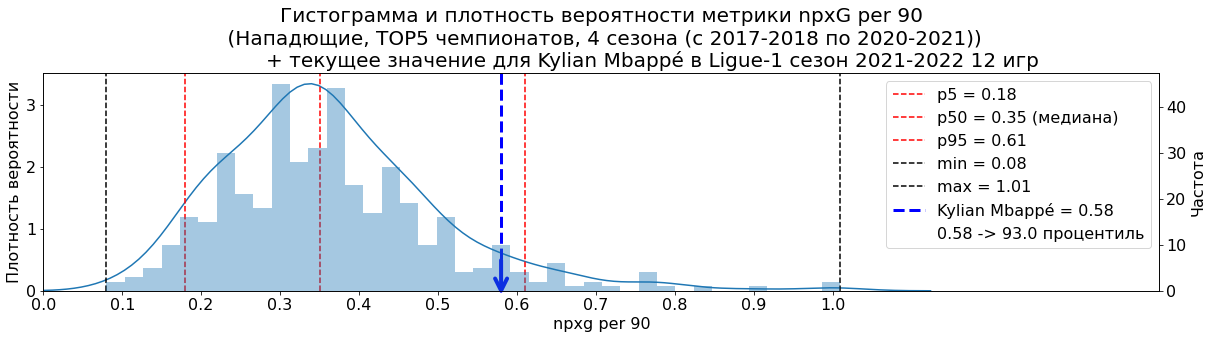

In [64]:
fig, ax = plt.subplots(1,1, figsize=(20,4))

df_old = DF_outfields_OLD_ALL.copy()
df_now = DF_outfields_NOW_ALL.copy()

league_name = 'Ligue-1'
player = 'Kylian Mbappé'

mask1 = (df_old.position == 'FW') & (df_old['minutes_90s'] >19) 
mask2 = df_now.player == 'Kylian Mbappé'

#вся статистика по метрике npxg_per90 за 4 сезона по TOP5 лигам
df1 = df_old[mask1]['npxg_per90']

bins = 40
first_ax  = sns.distplot(df1, ax=ax, bins=bins, hist=False)
second_ax = ax.twinx()
sns.distplot(df1, kde=False, ax=second_ax, bins=bins)

#расчет перцентилей и граничных значений

metric_p_5 = round(np.percentile(df1,5),2)
metric_p_50 = round(np.percentile(df1,50),2)
metric_p_95 = round(np.percentile(df1,95),2)
metric_min = round(df1.min(),2)
metric_max = round(df1.max(),2)

metric = df_now[mask2]['npxg_per90'].values[0]

perc_metric = get_perc_by_metric(metric, df1)


ax.set_xlim(0, metric_max*1.4)
ax.set_ylim(0)
ax.axvline(metric_p_5, ls='--', c='r')
ax.axvline(metric_p_50, ls='--', c='r')
ax.axvline(metric_p_95, ls='--', c='r')
ax.axvline(metric_min, ls='--', c='black')
ax.axvline(metric_max, ls='--', c='black')
ax.axvline(metric, ls='--', c='b', lw='3')

y_min = ax.get_ylim()[0]
y_max = ax.get_ylim()[1]
ax.annotate("", xy=(metric, y_max*0.15), xytext=(metric, y_min-0.1),
                 arrowprops=dict(arrowstyle="<-", color='blue',linewidth=4), 
                 fontsize=30)

ax.plot(0,0, c='white')
ax.legend([
#            f'',
           f'p5 = {metric_p_5}',
           f'p50 = {metric_p_50} (медиана)',
           f'p95 = {metric_p_95}',
           f'min = {metric_min}',
           f'max = {metric_max}',
           f'{player} = {metric}',
           f'{metric} -> {perc_metric} процентиль'], fontsize=16)

# leg = ax.get_legend()
# leg.legendHandles[0].set_visible(False)

ax.set_title(f'Гистограмма и плотность вероятности метрики npxG per 90\n (Нападющие, TOP5 чемпионатов, 4 сезона (с 2017-2018 по 2020-2021))\n\
                + текущее значение для {player} в {league_name} сезон 2021-2022 12 игр', fontsize=20)

ax.set_ylabel('Плотность вероятности', fontsize=16)
ax.set_xlabel('npxg per 90', fontsize=16)
second_ax.set_ylabel('Частота', fontsize=16)

ax.set_xticks(np.arange(0, round(metric_max)+0.1, 0.1))


plt.show()

### Отрисовываем все распределения в упрощенном варианте

- посчитанные значения процентилей сохраняем для использования в качестве границ радара

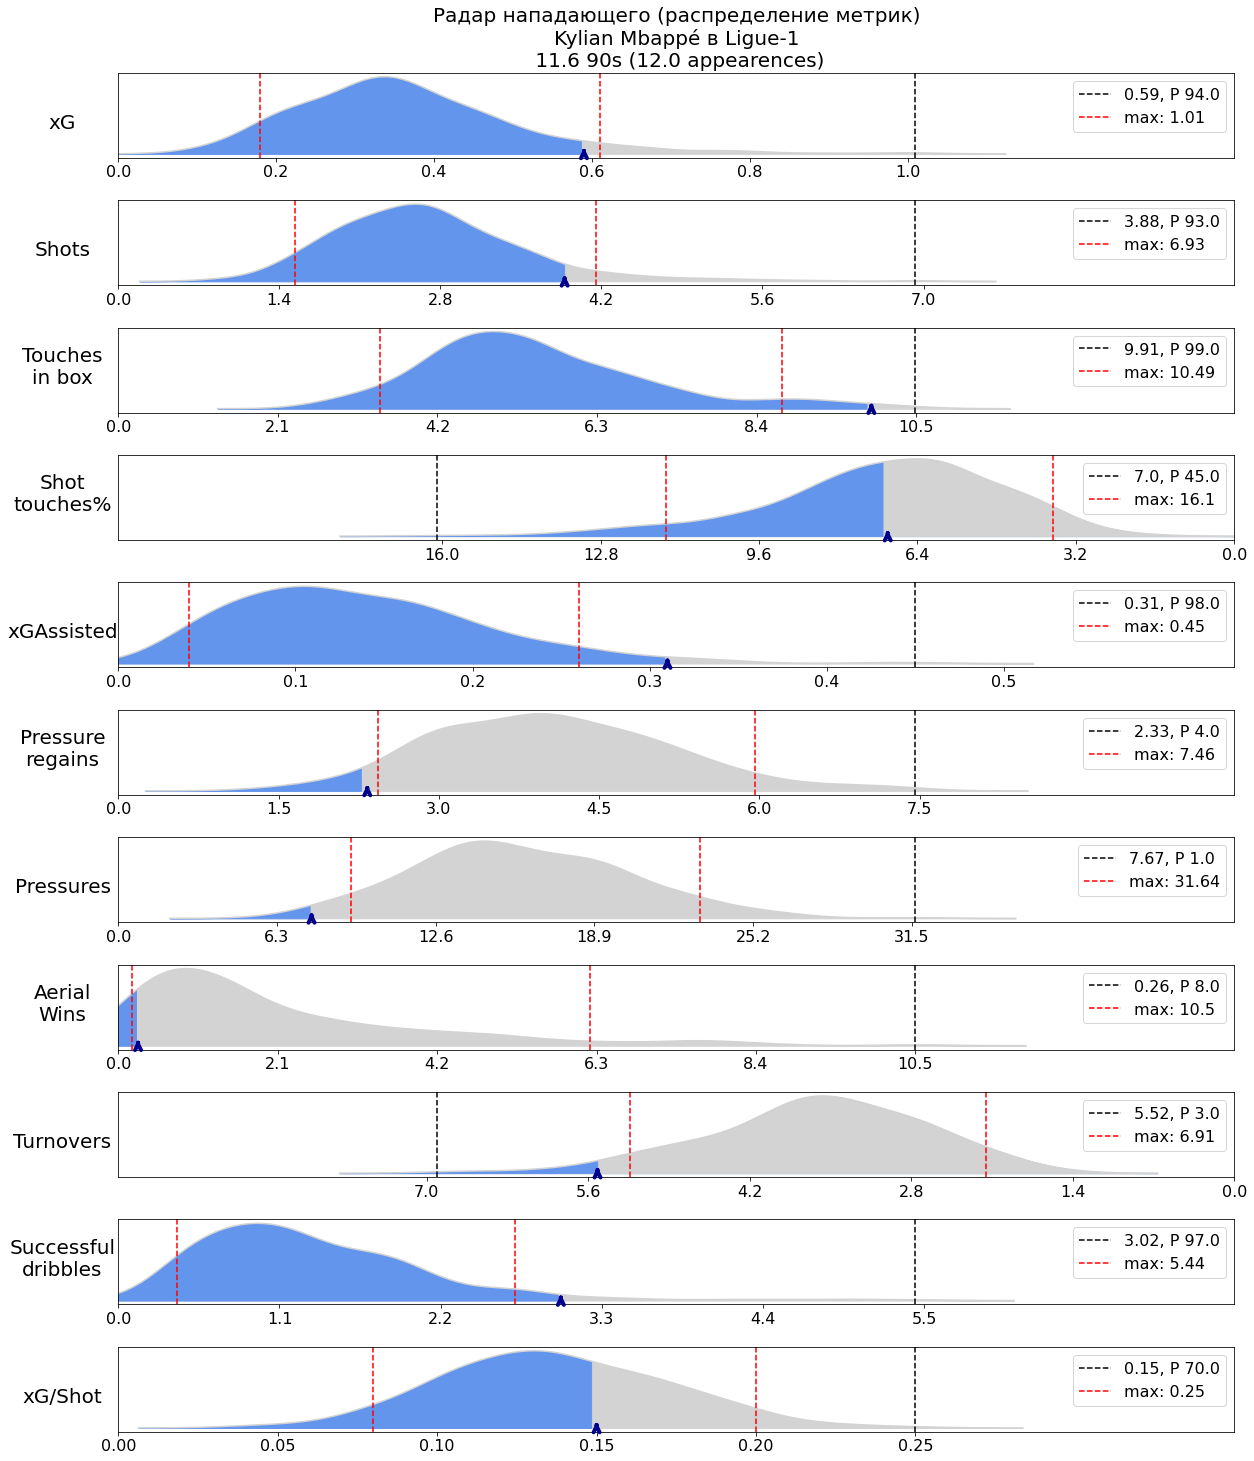

In [65]:
fig, ax = plt.subplots(11,1, figsize=(20,25))

df_old = DF_outfields_OLD_ALL.copy()
df_now = DF_outfields_NOW_ALL.copy()
df_metrics_ = df_metrics.iloc[3:].reset_index()

league_name = 'Ligue-1'
player = 'Kylian Mbappé'

mask1 = (df_old.position == 'FW') & (df_old['minutes_90s'] >19) 
mask2 = df_now.player == 'Kylian Mbappé'

time_90s = df_now[mask2]['minutes_90s'].values[0]
games = df_now[mask2]['games'].values[0]

df1 = df_old[mask1]['npxg_per90']
df2 = df_old[mask1]['shots_total_per90'] 
df3 = df_old[mask1]['touches_att_pen_area'] / df_old[mask1]['minutes_90s']
df4 = df_old[mask1]['shots_total'] / df_old[mask1]['touches'] *100
df5 = df_old[mask1]['xa_per90']
df6 = df_old[mask1]['pressure_regains'] / df_old[mask1]['minutes_90s']
df7 = df_old[mask1]['pressures'] / df_old[mask1]['minutes_90s']
df8 = df_old[mask1]['aerials_won'] / df_old[mask1]['minutes_90s']
df9 = (df_old[mask1]['miscontrols'] + (df_old[mask1]['dribbles'] - df_old[mask1]['dribbles_completed'])) \
       / df_old[mask1]['minutes_90s']
df10 = df_old[mask1]['dribbles_completed'] / df_old[mask1]['minutes_90s']
df11 = df_old[mask1]['npxg_per_shot']

bins = 40
for num, df_ in enumerate([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]):

    sns.distplot(df_, ax=ax[num], bins=bins, hist=False, color='lightgray')

    #значения, рассчитанные на истории
    metric_p_5 = round(np.percentile(df_,5),2)
    metric_p_50 = round(np.percentile(df_,50),2)
    metric_p_95 = round(np.percentile(df_,95),2)
    metric_min = round(df_.min(),2)
    metric_max = round(df_.max(),2)
    
    #значения, рассчитанные для конкретного футболиста по текущему сезону
    metric = df_metrics_.loc[num,'Statistic']
    metric_name = df_metrics_.loc[num,'index']
    perc_metric = get_perc_by_metric(metric, df_)
    
    #для метрик Shot touches% и Turnovers оси на оригинальном радаре инвертированы 
    #чтобы получить искомый процентиль - нужно из 100 отнять полученное выше значение
    
    if (num == 3) or (num == 8):

        proxy = metric_p_5
        metric_p_5 = metric_p_95
        metric_p_95 = proxy
        perc_metric = 100 - perc_metric
    
    #сохраняем границы для построения радара
    df_metrics_.loc[num, 'p5'] = [metric_p_5]
    df_metrics_.loc[num, 'p95'] = [metric_p_95]
    df_metrics_.loc[num, 'p_metr'] = [perc_metric]
    
    
#     ax[num].axvline(metric, ls='--', c='darkblue', lw='3')
#     ax[num].plot(0,0, c='white')
    y_lim_min = ax[num].get_ylim()[0]
    y_lim_max = ax[num].get_ylim()[1]
    ax[num].annotate("", xy=(metric, 0), xytext=(metric, y_lim_max*0.1),
                 arrowprops=dict(arrowstyle="<-", color='darkblue',linewidth=4), 
                 fontsize=15)
    ax[num].axvline(metric_max, ls='--', c='black')
    ax[num].axvline(metric_p_5, ls='--', c='r')
    ax[num].axvline(metric_p_95, ls='--', c='r')

    
    ax[num].legend([
#                     '',
                    f'{round(metric,2)}, P {perc_metric}',
#                     f'P {perc_metric}',
                    f'max: {metric_max}'], fontsize=16, loc=1)
    
#     leg = ax[num].get_legend()
#     leg.legendHandles[0].set_visible(False)
    
    kde_x, kde_y = ax[num].lines[0].get_data()
    ax[num].fill_between(kde_x, kde_y, color='lightgray')
    ax[num].fill_between(kde_x, kde_y, where=(kde_x<=round(metric,5)), color='cornflowerblue')
    
    if num != 10:
        ax[num].set_xticks(np.arange(0, round(metric_max,1)+0.1*metric_max, round(metric_max/5,1)))
    elif num == 10:
        ax[num].set_xticks(np.arange(0, round(metric_max,2)+0.1*metric_max, round(metric_max/5,2)))
    
    if (num != 3) and (num != 8):
        ax[num].set_xlim(0, metric_max*1.4)
    elif (num == 3) or (num == 8):
        ax[num].fill_between(kde_x, kde_y, color='lightgray')
        ax[num].fill_between(kde_x, kde_y, where=(kde_x>=metric), color='cornflowerblue')
        ax[num].invert_xaxis()
        ax[num].set_xlim(metric_max*1.4, 0)
        
    ax[num].set_xlabel('')
    ax[num].set_yticks([])
    ax[num].set_ylabel(metric_name if len(metric_name.split(' ',1)) == 1 else 
                       metric_name.split(' ',1)[0] + '\n' + metric_name.split(' ',1)[1], fontsize=20, rotation=0)
    ax[num].yaxis.set_label_coords(-0.05,0.3)

    
ax[0].set_title(f'Радар нападающего (распределение метрик)\n{player} в {league_name}\n {time_90s} 90s ({games} appearences)', fontsize=20)


plt.subplots_adjust(hspace=0.5)

### 8.3 Строим радар

In [66]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Kylian Mbappé'
squad = df_now[df_now.player == player]['squad'].values[0]

#### - получим параметры для построения радара

In [67]:
df_metrics_

,index,Statistic,p5,p95,p_metr
0,xG,0.59,0.18,0.61,94.0
1,Shots,3.88,1.54,4.15,93.0
2,Touches in box,9.91,3.45,8.74,99.0
3,Shot touches%,7,11.47,3.67,45.0
4,xGAssisted,0.31,0.04,0.26,98.0
5,Pressure regains,2.33,2.43,5.96,4.0
6,Pressures,7.67,9.24,23.10,1.0
7,Aerial Wins,0.26,0.18,6.21,8.0
8,Turnovers,5.52,5.24,2.15,3.0
9,Successful dribbles,3.02,0.40,2.71,97.0


In [68]:
ranges = df_metrics_[['p5','p95']].apply(lambda x: (x[0], x[1]), axis=1).values
values = df_metrics_.Statistic.values
params = df_metrics_['index']

df_now = DF_outfields_NOW_ALL.copy()
time_90s = df_now[mask2]['minutes_90s'].values[0]
games = df_now[mask2]['games'].values[0]

In [69]:
radar = Radar(label_fontsize=12, range_fontsize=9)

title = dict(
    title_name=player,
    subtitle_name=f'PSG (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)

endnote = "Visualization made by: @footsci\nAll units are in per90"

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


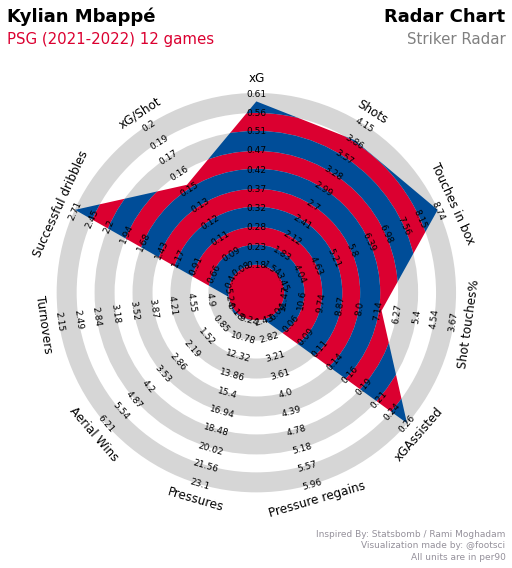

In [70]:
fig, ax = radar.plot_radar(ranges=ranges, params=params, values=values, 
                                 radar_color=['#DB0030', '#004D98'],title=title, endnote = endnote,dpi=1500)

#### Сравнение метрик StatsBomb и fbref

In [71]:
df_metrics_['Statistic_SB'] = [0.53, 3.62, 10.06, 4, 0.32, 1.37, 7.62, 0.29, 5.57, 2.93, 0.15]
df_metrics_['p5_SB'] = [0.19, 1.6, 4.6, 9, 0.05, 1.5, 12, 0.6, 4.7, 0.5, 0.09]
df_metrics_['p95_SB'] = [0.57, 3.9, 12.9, 2, 0.23, 3.7, 26, 4.8, 1.9, 2.2, 0.21]
df_metrics_['p_metr_SB'] = [92, 94, 97, 56, 99, 13, 1, 6, 3, 98, 61]

In [72]:
df_metrics_['Statistic_diff_%'] = ((df_metrics_['Statistic'] - df_metrics_['Statistic_SB']) / df_metrics_['Statistic_SB'] * 100)
df_metrics_['p5_diff_%'] =  ((df_metrics_['p5'] - df_metrics_['p5_SB']) / df_metrics_['p5_SB'] * 100)
df_metrics_['p95_diff_%'] =  ((df_metrics_['p95'] - df_metrics_['p95_SB']) / df_metrics_['p95_SB'] * 100)
df_metrics_['p_metr_diff_abs'] =  (df_metrics_['p_metr_SB'] - df_metrics_['p_metr'])

In [73]:
for col in df_metrics_.columns[1:]:

    df_metrics_[col] = df_metrics_[col].apply(lambda x: round(x,2))
df_metrics_

,index,Statistic,p5,p95,p_metr,Statistic_SB,p5_SB,p95_SB,p_metr_SB,Statistic_diff_%,p5_diff_%,p95_diff_%,p_metr_diff_abs
0,xG,0.59,0.18,0.61,94.0,0.53,0.19,0.57,92,11.32,-5.26,7.02,-2.0
1,Shots,3.88,1.54,4.15,93.0,3.62,1.60,3.90,94,7.18,-3.75,6.41,1.0
2,Touches in box,9.91,3.45,8.74,99.0,10.06,4.60,12.90,97,-1.49,-25.00,-32.25,-2.0
3,Shot touches%,7.00,11.47,3.67,45.0,4.00,9.00,2.00,56,75.00,27.44,83.50,11.0
4,xGAssisted,0.31,0.04,0.26,98.0,0.32,0.05,0.23,99,-3.13,-20.00,13.04,1.0
5,Pressure regains,2.33,2.43,5.96,4.0,1.37,1.50,3.70,13,70.07,62.00,61.08,9.0
6,Pressures,7.67,9.24,23.10,1.0,7.62,12.00,26.00,1,0.66,-23.00,-11.15,0.0
7,Aerial Wins,0.26,0.18,6.21,8.0,0.29,0.60,4.80,6,-10.34,-70.00,29.38,-2.0
8,Turnovers,5.52,5.24,2.15,3.0,5.57,4.70,1.90,3,-0.90,11.49,13.16,0.0
9,Successful dribbles,3.02,0.40,2.71,97.0,2.93,0.50,2.20,98,3.07,-20.00,23.18,1.0


### Statistic разница

#### - Shot touches% лучше не смотреть на разницу в процентах (% от %)

In [74]:
df_metrics_[['index','Statistic','Statistic_SB','Statistic_diff_%']]

,index,Statistic,Statistic_SB,Statistic_diff_%
0,xG,0.59,0.53,11.32
1,Shots,3.88,3.62,7.18
2,Touches in box,9.91,10.06,-1.49
3,Shot touches%,7.00,4.00,75.00
4,xGAssisted,0.31,0.32,-3.13
5,Pressure regains,2.33,1.37,70.07
6,Pressures,7.67,7.62,0.66
7,Aerial Wins,0.26,0.29,-10.34
8,Turnovers,5.52,5.57,-0.90
9,Successful dribbles,3.02,2.93,3.07


### p5 разница

In [76]:
df_metrics_[['index','p5','p5_SB','p5_diff_%']]

,index,p5,p5_SB,p5_diff_%
0,xG,0.18,0.19,-5.26
1,Shots,1.54,1.60,-3.75
2,Touches in box,3.45,4.60,-25.00
3,Shot touches%,11.47,9.00,27.44
4,xGAssisted,0.04,0.05,-20.00
5,Pressure regains,2.43,1.50,62.00
6,Pressures,9.24,12.00,-23.00
7,Aerial Wins,0.18,0.60,-70.00
8,Turnovers,5.24,4.70,11.49
9,Successful dribbles,0.40,0.50,-20.00


### p95 разница

In [77]:
df_metrics_[['index','p95','p95_SB','p95_diff_%']]

,index,p95,p95_SB,p95_diff_%
0,xG,0.61,0.57,7.02
1,Shots,4.15,3.90,6.41
2,Touches in box,8.74,12.90,-32.25
3,Shot touches%,3.67,2.00,83.50
4,xGAssisted,0.26,0.23,13.04
5,Pressure regains,5.96,3.70,61.08
6,Pressures,23.10,26.00,-11.15
7,Aerial Wins,6.21,4.80,29.38
8,Turnovers,2.15,1.90,13.16
9,Successful dribbles,2.71,2.20,23.18


### p_metr разница

In [78]:
df_metrics_[['index','p_metr','p_metr_SB','p_metr_diff_abs']]

,index,p_metr,p_metr_SB,p_metr_diff_abs
0,xG,94.0,92,-2.0
1,Shots,93.0,94,1.0
2,Touches in box,99.0,97,-2.0
3,Shot touches%,45.0,56,11.0
4,xGAssisted,98.0,99,1.0
5,Pressure regains,4.0,13,9.0
6,Pressures,1.0,1,0.0
7,Aerial Wins,8.0,6,-2.0
8,Turnovers,3.0,3,0.0
9,Successful dribbles,97.0,98,1.0


#### 8.4 Готовые функция для построения радаров (нападающих)

In [79]:
def get_player_data(df_now, player):
                    
    df = df_now.copy()
    df_metrics = pd.DataFrame()
    mask = (df.player == player)

    time_90s = df[mask]['minutes_90s'].values[0]
    games = df[mask]['games'].values[0]

    df_metrics['player'] =              [player]
    df_metrics['appearances'] =         [games]
    df_metrics['90s_played'] =          [time_90s]
    df_metrics['xG'] =                  round(df[mask]['npxg'].values[0] / time_90s,2)
    df_metrics['Shots'] =               round(df[mask]['shots_total'].values[0] / time_90s,2)
    df_metrics['Touches in box'] =      round(df[mask]['touches_att_pen_area'].values[0] / time_90s,2)
    df_metrics['Shot touches%'] =       round(df[mask]['shots_total'] / df[mask]['touches'],2).values[0]*100
    df_metrics['xGAssisted'] =          round(df[mask]['xa'].values[0] / time_90s,2) 
    df_metrics['Pressure regains'] =    round(df[mask]['pressure_regains'].values[0] / time_90s,2)
    df_metrics['Pressures'] =           round(df[mask]['pressures'].values[0] / time_90s,2) 
    df_metrics['Aerial Wins'] =         round(df[mask]['aerials_won'].values[0] / time_90s,2)

    mis = df[mask]['miscontrols'].values[0]
    drib_failed = df[mask]['dribbles'].values[0] - df[mask]['dribbles_completed'].values[0]

    df_metrics['Turnovers'] =           round((mis + drib_failed) / time_90s,2)
    df_metrics['Successful dribbles'] = round(df[mask]['dribbles_completed'].values[0] / time_90s,2)
    df_metrics['xG/Shot'] =             round(df[mask]['npxg_per_shot'].values[0] ,2)
    df_metrics = df_metrics.T
    df_metrics.columns = ['Statistic']
                    
    return df_metrics

In [80]:
def get_radar_data(df_old, df_now, df_metrics, league_name, player, _90s_min, position):
    
    df_metrics_ = df_metrics.iloc[3:].reset_index()
    
    mask1 = (df_old.position == position) & (df_old['minutes_90s'] >= _90s_min) 
    mask2 = df_now.player == player

    time_90s = df_now[mask2]['minutes_90s'].values[0]
    games = df_now[mask2]['games'].values[0]

    df1 = df_old[mask1]['npxg_per90']
    df2 = df_old[mask1]['shots_total_per90'] 
    df3 = df_old[mask1]['touches_att_pen_area'] / df_old[mask1]['minutes_90s']
    df4 = df_old[mask1]['shots_total'] / df_old[mask1]['touches'] *100
    df5 = df_old[mask1]['xa_per90']
    df6 = df_old[mask1]['pressure_regains'] / df_old[mask1]['minutes_90s']
    df7 = df_old[mask1]['pressures'] / df_old[mask1]['minutes_90s']
    df8 = df_old[mask1]['aerials_won'] / df_old[mask1]['minutes_90s']
    df9 = (df_old[mask1]['miscontrols'] + (df_old[mask1]['dribbles'] - df_old[mask1]['dribbles_completed'])) \
           / df_old[mask1]['minutes_90s']
    df10 = df_old[mask1]['dribbles_completed'] / df_old[mask1]['minutes_90s']
    df11 = df_old[mask1]['npxg_per_shot']

    for num, df_ in enumerate([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]):


        #значения, рассчитанные на истории
        metric_p_5 = round(np.percentile(df_,5),2)
        metric_p_95 = round(np.percentile(df_,95),2)

        #значения, рассчитанные для конкретного футболиста по текущему сезону
        metric = df_metrics_.loc[num,'Statistic']
        metric_name = df_metrics_.loc[num,'index']
        perc_metric = get_perc_by_metric(metric, df_)
    
    #для метрик Shot touches% и Turnovers оси на оригинальном радаре инвертированы 
    #чтобы получить искомый процентиль - нужно из 100 отнять полученное выше значение
    
        if (num == 3) or (num == 8):

            proxy = metric_p_5
            metric_p_5 = metric_p_95
            metric_p_95 = proxy
            perc_metric = 100 - perc_metric
    
        #сохраняем границы для построения радара
        df_metrics_.loc[num, 'p5'] = [metric_p_5]
        df_metrics_.loc[num, 'p95'] = [metric_p_95]
        df_metrics_.loc[num, 'p_metr'] = [perc_metric]
    
    return df_metrics_

In [81]:
def radar_plot(radar_data, df_now, title):

    ranges = radar_data[['p5','p95']].apply(lambda x: (x[0], x[1]), axis=1).values
    values = radar_data.Statistic.values
    params = radar_data['index']
    
    radar = Radar(label_fontsize=12, range_fontsize=9)

    endnote = "Visualization made by: @footsci\nAll units are in per90"

    fig, ax = radar.plot_radar(ranges=ranges, params=params, values=values, 
                                     radar_color=['#DB0030', '#004D98'],title=title, endnote = endnote,dpi=1500)

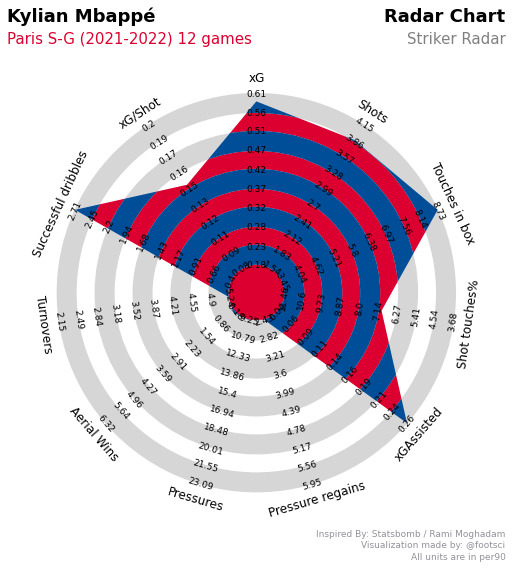

In [82]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Kylian Mbappé'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)


#### Рассмотрим TOP10 нападающих по npxg 2021-2022

In [83]:
# DF_outfields_NOW_ALL

In [84]:
mask = (DF_outfields_NOW_ALL['minutes_90s'] >= 5) & (DF_outfields_NOW_ALL['npxg_per90'] >= 0.61)
DF_outfields_NOW_ALL[mask].sort_values('npxg_per90',ascending=False)[['player','squad','minutes_90s','npxg_per90']].head(15).reset_index(drop=True)

,player,squad,minutes_90s,npxg_per90
0,Robert Lewandowski,Bayern Munich,10.1,1.03
1,Patrik Schick,Leverkusen,7.8,0.79
2,Erling Haaland,Dortmund,6.0,0.76
3,Yussuf Poulsen,RB Leipzig,5.4,0.73
4,Sadio Mané,Liverpool,10.2,0.69
5,Leroy Sané,Bayern Munich,7.7,0.69
6,Arnaut Groeneveld,Villarreal,7.8,0.68
7,Lukas Nmecha,Wolfsburg,6.2,0.61
8,Mohamed Bayo,Clermont Foot,10.1,0.61
9,Gaëtan Laborde,Rennes,8.5,0.61


In [85]:
DF_outfields_NOW_ALL

,season,league_name,player,nationality,position,squad,age,birth_year,games,games_starts,...,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct
0,2021-2022,Premier-League,Max Aarons,eng ENG,DF,Norwich City,21-314,2000,11.0,11.0,...,7.0,20.0,1.0,0.0,0.0,1.0,58.0,5.0,20.0,20.0
1,2021-2022,Premier-League,Che Adams,sct SCO,"FW,MF",Southampton,25-124,1996,8.0,7.0,...,13.0,15.0,2.0,0.0,0.0,0.0,35.0,16.0,34.0,32.0
2,2021-2022,Premier-League,Rayan Aït Nouri,fr FRA,DF,Wolves,20-161,2001,4.0,3.0,...,4.0,4.0,0.0,0.0,0.0,0.0,24.0,0.0,3.0,0.0
3,2021-2022,Premier-League,Kristoffer Ajer,no NOR,DF,Brentford,23-211,1998,7.0,6.0,...,2.0,10.0,0.0,0.0,0.0,0.0,55.0,21.0,9.0,70.0
4,2021-2022,Premier-League,Nathan Aké,nl NED,DF,Manchester City,26-269,1995,3.0,3.0,...,4.0,0.0,0.0,0.0,0.0,0.0,17.0,14.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,2021-2022,Ligue-1,Burak Yılmaz,tr TUR,FW,Lille,36-122,1985,11.0,11.0,...,7.0,10.0,16.0,1.0,0.0,0.0,32.0,13.0,26.0,33.3
2367,2021-2022,Ligue-1,Zaydou Youssouf,fr FRA,MF,Saint-Étienne,22-126,1999,10.0,7.0,...,9.0,9.0,1.0,0.0,0.0,1.0,70.0,6.0,3.0,66.7
2368,2021-2022,Ligue-1,Akim Zedadka,fr FRA,DF,Clermont Foot,26-168,1995,13.0,13.0,...,11.0,37.0,1.0,0.0,0.0,0.0,102.0,12.0,14.0,46.2
2369,2021-2022,Ligue-1,Mehdi Zerkane,dz ALG,"MF,DF",Bordeaux,22-122,1999,6.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0


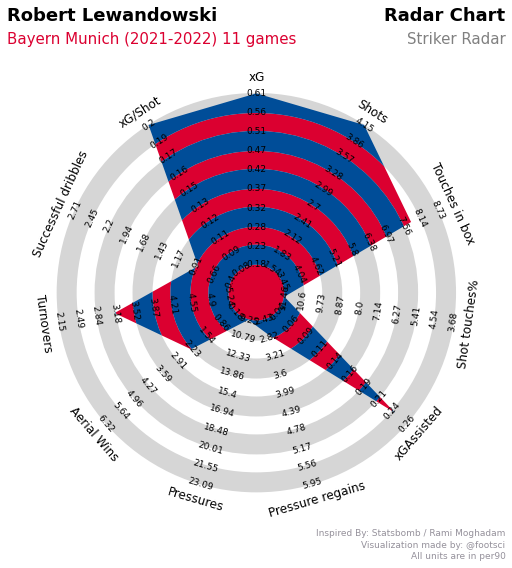

In [86]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Robert Lewandowski'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)


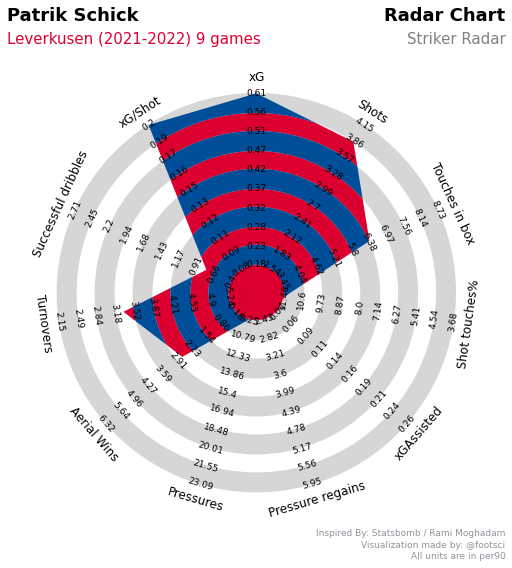

In [87]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Patrik Schick'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)


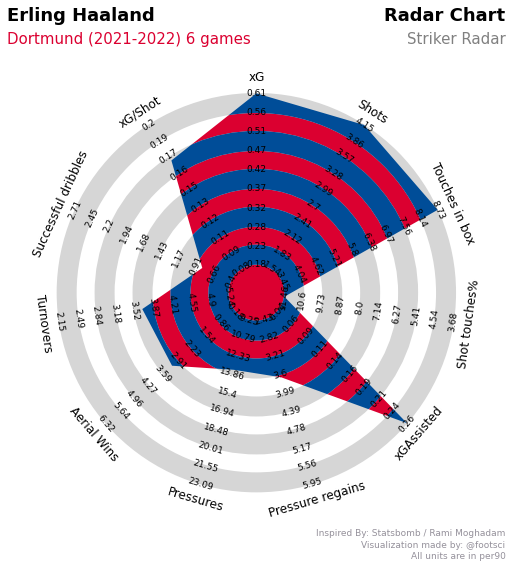

In [88]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Erling Haaland'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)


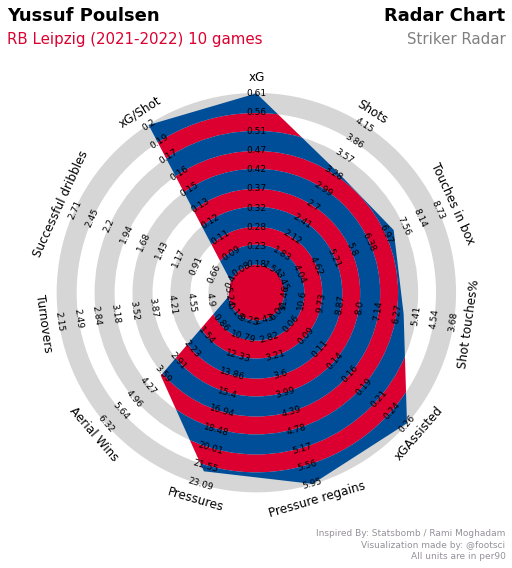

In [89]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Yussuf Poulsen'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)

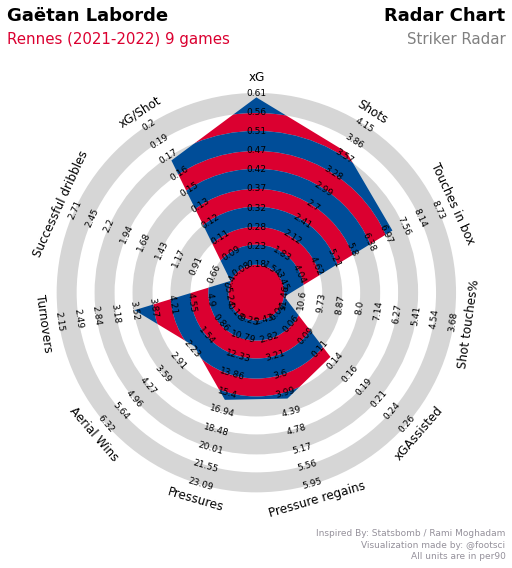

In [90]:
df_now = DF_outfields_NOW_ALL.copy()
player = 'Gaëtan Laborde'

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]
league = df_now[mask]['league_name'].values[0]

player_statistics = get_player_data(DF_outfields_NOW_ALL, player)
radar_data = get_radar_data(DF_outfields_OLD_ALL, DF_outfields_NOW_ALL, player_statistics, league, player, 19, 'FW')

mask = df_now.player == player
games = df_now[mask]['games'].values[0]
squad = df_now[mask]['squad'].values[0]

title = dict(
    title_name=player,
    subtitle_name=f'{squad} (2021-2022) {int(games)} games',
    subtitle_color='#DB0030',
    title_name_2='Radar Chart',
    subtitle_name_2='Striker Radar',
    subtitle_color_2='gray',
    title_fontsize=18,
    subtitle_fontsize=15,
)
radar_plot(radar_data, player, title)